#### Downstream Pipeline to Assess Impact of Denoising

In [10]:
import scanpy as sc
# from magic import MAGIC
import scipy.sparse as sp
import scanpy.external as sce
import numpy as np

context_path = "/home/sah2p/ondemand/singlecell_data/"
organism = 'Arabidopsis/'
adata = sc.read_h5ad(context_path+organism+"SRP166333_magic_denoised.h5ad")


In [11]:

dropout_rate = np.mean(adata.X == 0) * 100  # Percentage of zeros in the dataset
print(f"Dropout Rate: {dropout_rate:.2f}%")

Dropout Rate: 0.00%


In [13]:
unique_genes_per_cell = np.sum(adata.X > 0, axis=1)
print(f"Mean unique genes per cell: {np.mean(unique_genes_per_cell):.2f}")

Mean unique genes per cell: 274.89


/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


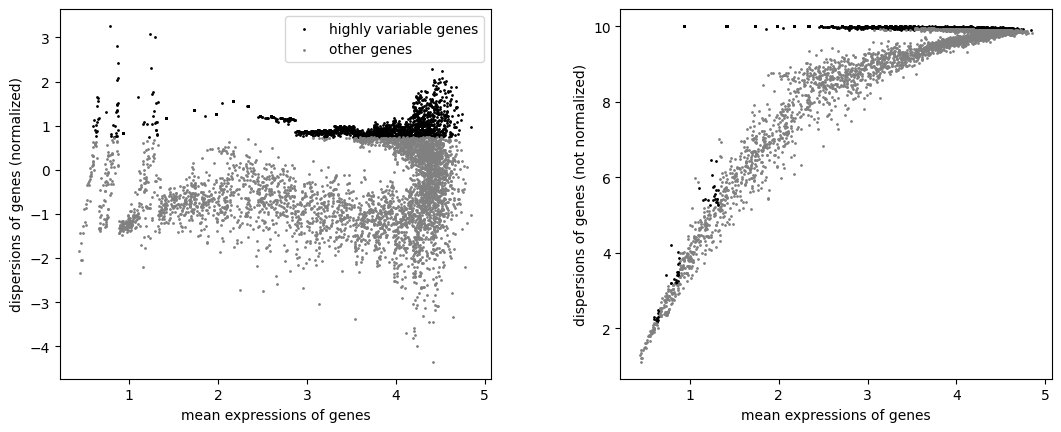

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)  # Visualization

/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

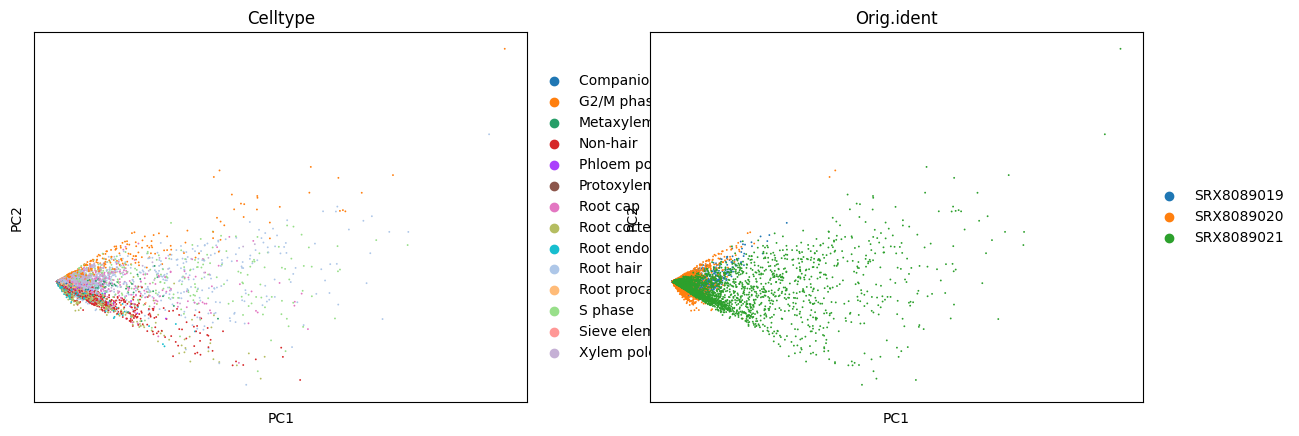

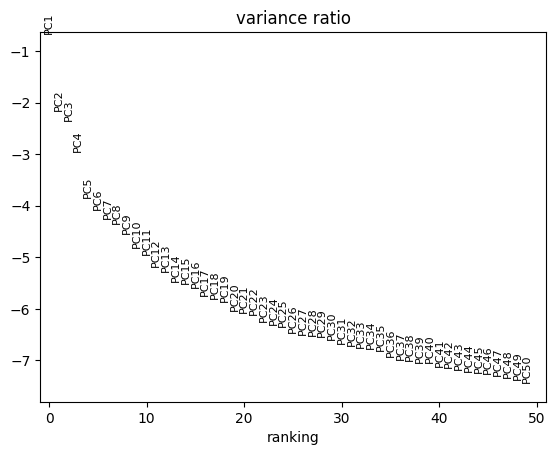

In [9]:
sc.tl.pca(adata, n_comps=50, random_state=0)
# Plot PCA  
sc.pl.pca(adata, color=["Celltype", "Orig.ident"], save="03_clustering_PCA.png")
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save="04_clustering_PCA.png")


### 02 Clustering and Cell Type Annotation

In [3]:
def process_adata(adata):
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

process_adata(raw_adata)
process_adata(denoised_adata)

In [7]:
denoised_adata.obs['Orig.ident'].unique()

['SRX8089019', 'SRX8089020', 'SRX8089021']
Categories (3, object): ['SRX8089019', 'SRX8089020', 'SRX8089021']

In [4]:
raw_adata

AnnData object with n_obs × n_vars = 16949 × 53678
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE'
    var: 'features'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

01 Assess UMAP and clustering performance

In [ ]:
def process_adata(adata):
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

process_adata(raw_adata)
process_adata(denoised_adata)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Ensure raw and denoised data are in dense format
# raw_data = adata.raw.X.A if isinstance(adata.raw.X, np.ndarray) else adata.raw.X.toarray()
# denoised_data = adata.X.A if isinstance(adata.X, np.ndarray) else adata.X.toarray()

# Compute per-gene Pearson correlation
gene_correlations = [
    pearsonr(raw_adata[:, i], denoised_adata[:, i])[0] 
    for i in range(raw_adata.shape[1])
]

# Convert to DataFrame for easy analysis
correlation_df = pd.DataFrame({
    "Gene": raw_adata.var_names,
    "Correlation": gene_correlations
})

# Save correlation results
correlation_df.to_csv("correlation_analysis.csv", index=False)

# Plot correlation distribution
plt.figure(figsize=(8, 5))
sns.histplot(correlation_df["Correlation"], bins=50, kde=True)
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of Gene Expression Correlation (Raw vs Denoised)")
plt.savefig("correlation_distribution.png")
plt.show()

# # Scatter plot for a few random genes
# num_genes_to_plot = 10
# sample_genes = np.random.choice(adata.var_names, num_genes_to_plot, replace=False)

# plt.figure(figsize=(10, 6))
# for gene in sample_genes:
#     gene_idx = list(adata.var_names).index(gene)
#     plt.scatter(raw_data[:, gene_idx], denoised_data[:, gene_idx], alpha=0.3, label=gene)

# plt.xlabel("Raw Expression")
# plt.ylabel("Denoised Expression")
# plt.legend()
# plt.title("Raw vs Denoised Gene Expression for Sampled Genes")
# plt.savefig("scatter_raw_vs_denoised.png")
# plt.show()

In [18]:
stats_d

{'Mean': 0.10327620649334084,
 'Standard Deviation': 1.6603740199189523,
 'Min': -14.304604468089892,
 'Max': 772.6249645914941,
 'Are All Values Integers': False}

In [19]:
# Compute Statistics
stats_raw = {
    "Mean": np.mean(raw_data),
    "Standard Deviation": np.std(raw_data),
    "Min": np.min(raw_data),
    "Max": np.max(raw_data),
    "Are All Values Integers": np.all(raw_data == raw_data.astype(int))
}

In [20]:
stats_raw

{'Mean': 0.10477097827916741,
 'Standard Deviation': 1.8288673960360964,
 'Min': 0.0,
 'Max': 1848.0,
 'Are All Values Integers': True}

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


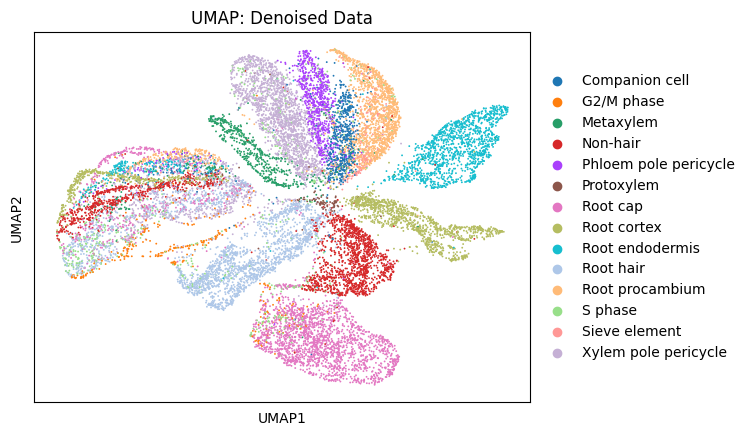

In [23]:
# Compute UMAP on raw data
# sc.pp.neighbors(adata.raw)
# sc.tl.umap(adata.raw)
# sc.pl.umap(adata.raw, color='Celltype', title="UMAP: Raw Data")

# Compute UMAP on denoised data
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='Celltype', title="UMAP: Denoised Data")